<div align="right"><em>Машинне навчання. Лабораторний практикум</em></div>

# Лабораторна робота №7
## Навчання без вчителя: метод головних компонент і кластеризація


---


## Завдання

Необхідно:
- розібратися з тим, як працюють методи зниження розмірності і кластеризації даних; 
- ще раз попрактикуватися в задачі класифікації;
- дати відповіді (з написанням коду) на всі запитання сформульовані в лабораторній роботі.

#### Опис даних

Будемо працювати з набором даних [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Дані надходять з акселерометрів і гіроскопів мобільних телефонів Samsung Galaxy S3 (докладніше про ознаки – за посиланням на UCI вище), також відомий вид активності людини з телефоном в кишені – чи ходила вона, стояла, лежала, сиділа або йшла вгору/вниз по сходах.

Спочатку уявлятимемо, що вид активності нам невідомий, і спробуємо кластеризувати людей суто на основі наявних ознак. Потім розв'яжемо задачу визначення виду фізичної активності саме як задачу класифікації.

## Виконання завдання

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [4]:
X_train = np.loadtxt("../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [5]:
# Перевіримо розмірності
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризації нам не потрібен вектор міток, тому об'єднаємо `X_train` з `X_test` та `y_train` з `y_test`.

In [6]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Визначимо кількість унікальних значень міток цільового класу.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

Ці мітки відповідають:
- 1 - ходьбі
- 2 - підйому вгору по сходах
- 3 - спуску по сходах
- 4 - сидінню
- 5 - стоянню
- 6 - лежанню

Відмасштабуйте вибірку за допомогою `StandardScaler` з параметрами за замовчуванням.

In [12]:
# Ваш код тут
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Знижуємо розмірність за допомогою PCA, залишаючи стільки компонент, скільки потрібно для того, щоб пояснити як мінімум 90% дисперсії вихідних (відмасштабованих) даних. Використовуйте відмасштабовану вибірку і зафіксуйте `random_state` (константа RANDOM_STATE).

In [13]:
# Ваш код тут
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Запитання 1:** <br>
Яку мінімальну кількість головних компонент потрібно виділити, щоб пояснити 90% дисперсії вихідних (відмасштабованих) даних?

**Варіанти:**
- 56 
- 65
- 66
- 193

In [14]:
# Ваш код тут
print(f"Кількість компонент після PCA: {X_pca.shape[1]}")
print(f"Сумарна дисперсія: {sum(pca.explained_variance_ratio_):.4f}")

Кількість компонент після PCA: 65
Сумарна дисперсія: 0.9005


**Запитання 2:** <br>
Скільки відсотків дисперсії припадає на першу головну компоненту? Округліть до цілих відсотків.

**Варіанти:**
- 45
- 51
- 56
- 61

In [15]:
# Ваш код тут
perc_var_first = pca.explained_variance_ratio_[0] * 100
print(f"Перша головна компонента пояснює {perc_var_first:.2f}% дисперсії")

Перша головна компонента пояснює 50.74% дисперсії


Візуалізуйте дані в проекції на перші дві головні компоненти.

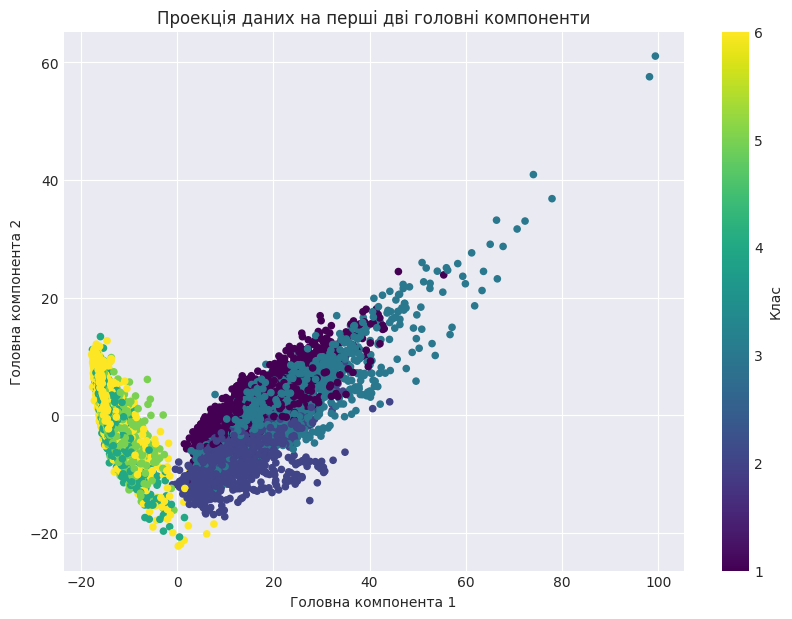

In [16]:
# Ваш код тут
plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],  # Перша головна компонента (PC1)
    X_pca[:, 1],  # Друга головна компонента (PC2)
    c=y,          # Кольори — за класами з y
    s=20, 
    cmap='viridis'
)
plt.xlabel('Головна компонента 1')
plt.ylabel('Головна компонента 2')
plt.title('Проекція даних на перші дві головні компоненти')
plt.colorbar(label='Клас')
plt.grid(True)
plt.show()


**Запитання 3:** <br>
Якщо все вийшло правильно, Ви побачите *певну кількість* кластерів, майже ідеально відокремлених один від одного. Які види активності входять в ці кластери? <br>

**Варіанти:**
- 1 кластер: всі 6 активностей
- 2 кластери: (ходьба, підйом вгору по сходах, спуск по сходах) і (сидіння, стояння, лежання)
- 3 кластери: (ходьба), (підйом вгору по сходах, спуск по сходах) і (сидіння, стояння, лежання)
- 6 кластерів

------------------------------

Зробіть кластеризацію даних методом `KMeans`, навчивши модель на даних зі зниженою за рахунок PCA розмірністю. В даному випадку ми підкажемо, що потрібно шукати саме 6 кластерів, але в загальному випадку ми не будемо знати, скільки кластерів треба шукати.

параметри:

- `n_clusters` = n_classes (кількість унікальних міток цільового класу)
- `n_init` = 100
- `random_state` = RANDOM_STATE (для відтворюваності результату)

Інші параметри зі значеннями за замовчуванням.

In [17]:
# Ваш код тут
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state= RANDOM_STATE)
kmeans.fit(X_pca)

y_kmeans = kmeans.labels_

Візуалізують дані в проекції на перші дві головні компоненти. Розфарбуйте точки відповідно до отриманих міток кластерів.

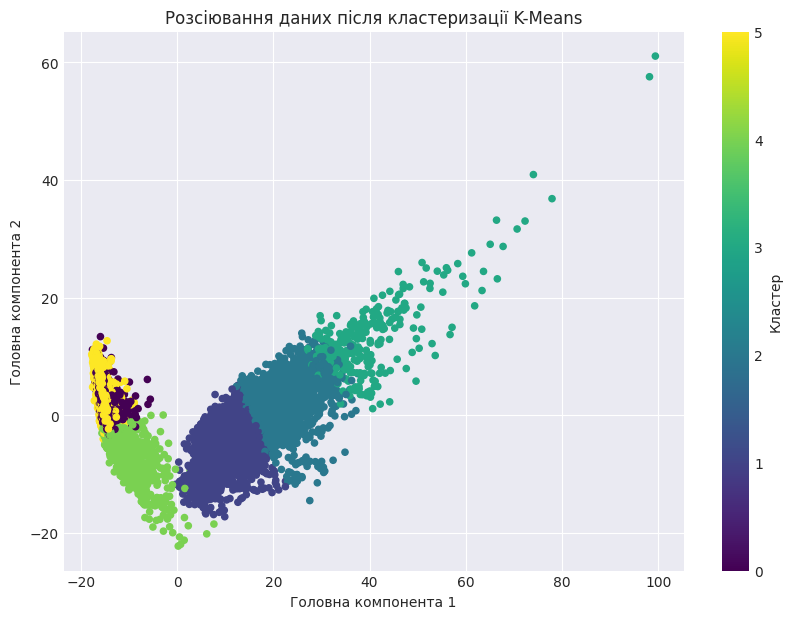

In [18]:
# Ваш код здесь
plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],  # Перша головна компонента (PC1)
    X_pca[:, 1],  # Друга головна компонента (PC2)
    c=y_kmeans,   # Розфарбовуємо точки за кластерами
    s=20, 
    cmap='viridis' # Колірна схема
)
plt.xlabel('Головна компонента 1')
plt.ylabel('Головна компонента 2')
plt.title('Розсіювання даних після кластеризації K-Means')
plt.colorbar(label='Кластер')
plt.grid(True)
plt.show()

Подивіться на відповідність між мітками кластерів і вихідними мітками класів і на те, які види активностей алгоритм `KMeans` плутає.

In [20]:
tab = pd.crosstab(y, y_kmeans, margins = True)
tab.index = ['ходьба', 'підйом вгору по сходах',
             'спуск по сходах', 'сидіння', 'стояння', 'лежання', 'всього']
tab.columns = ['cluster' + str(i + 1) for i in range (6)] + ['всього']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,всього
ходьба,0,903,741,78,0,0,1722
підйом вгору по сходах,0,1241,296,5,2,0,1544
спуск по сходах,0,320,890,196,0,0,1406
сидіння,1235,1,0,0,450,91,1777
стояння,1344,0,0,0,562,0,1906
лежання,52,5,0,0,329,1558,1944
всього,2631,2470,1927,279,1343,1649,10299


Бачимо, що кожному класу (тобто кожній активності) відповідають декілька кластерів. Давайте подивимося на максимальну частку об'єктів в класі, віднесених до якогось одного кластера. Це буде простою метрикою, що характеризує, наскільки легко клас відділяється від інших при кластеризації.

Приклад: якщо для класу "спуск по сходах", в якому 1406 об'єктів, розподіл кластерів такий:
 - кластер 2 – 320
 - кластер 3 – 890
 - кластер 4 – 196,
 
то така частка буде 890 / 1406 $\approx$ 0.63.
 

**Запитання 4:** <br>
Який вид активності відокремився від інших найкраще в термінах простої метрики, описаної вище? <br>

**Варіанти:**
- ходьба
- стояння
- спуск по сходах
- перераховані варіанти не підходять

In [26]:
# Ваш код тут
print("Ходьба" ,903 / 1722)
print("Стояння" ,1344/ 1944)
print("Спуск по сходах" ,890 / 1406)
print("Підйом по сходах" ,1241 / 1544)
print("Сидіння" ,1235 / 1777)
print("Лежання" ,1558 / 1944)

Ходьба 0.524390243902439
Стояння 0.691358024691358
Спуск по сходах 0.6330014224751067
Підйом по сходах 0.8037564766839378
Сидіння 0.694991558806978
Лежання 0.801440329218107


Видно, що kMeans не дуже добре відрізняє види активності один від одного. Використовуйте метод ліктя, щоб вибрати оптимальну кількість кластерів. Параметри алгоритму і дані використовуємо ті самі, що і раніше, міняємо тільки `n_clusters`.

In [28]:
# Ваш код тут
inertia = []
for k in range(1, n_classes + 1):
    #
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)  # X_pca — це твої дані після PCA
    inertia.append(kmeans.inertia_)
    #

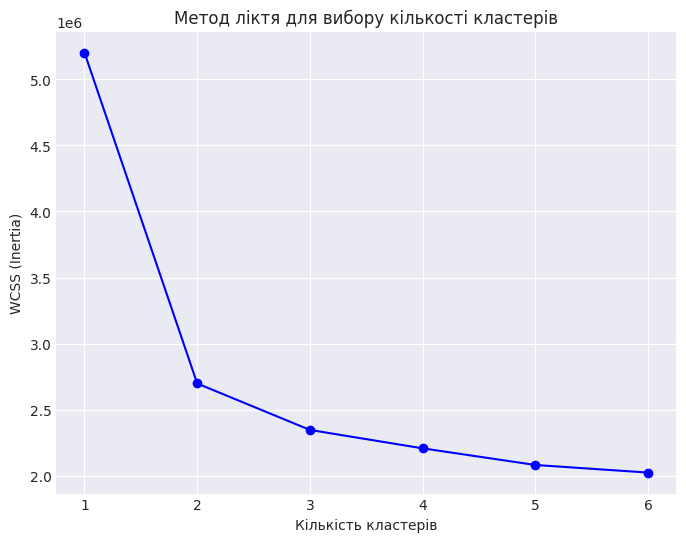

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linestyle='-', color='b')
plt.title('Метод ліктя для вибору кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

**Запитання 5:** <br>
Яку кількість кластерів оптимально вибрати, згідно з методом ліктя? <br>

**Варіанти:**
- 1
- 2 - +
- 3
- 4

------------------------

Спробуємо ще один метод кластеризації, який описувався в лекції – агломеративну кластеризацію.

In [30]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Порахуйте Adjusted Rand Index ( `sklearn.metrics`) для отриманого розбиття на кластери і для` KMeans` з параметрами із завдання до 4-ого запитання.

In [32]:
from sklearn.metrics import adjusted_rand_score
# Ваш код тут
ag_labels = ag.fit_predict(X_pca)  # Отримуємо мітки для агломеративної кластеризації

# KMeans кластеризація
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)  # Отримуємо мітки для KMeans

# Обчислення Adjusted Rand Index
ari_ag = adjusted_rand_score(y, ag_labels)  # y — істинні мітки
ari_kmeans = adjusted_rand_score(y, kmeans_labels)  # y — істинні мітки

print(f"ARI для агломеративної кластеризації: {ari_ag}")
print(f"ARI для KMeans кластеризації: {ari_kmeans}")

ARI для агломеративної кластеризації: 0.49362763373004886
ARI для KMeans кластеризації: 0.4198070012602345


**Запитання 6:** <br>
Виберіть всі вірні твердження.<br>

**Варіанти:**
- Згідно ARI, KMeans впорався з кластеризациєю гірше, ніж Agglomerative Clustering + 
- Для ARI не має значення які саме мітки присвоєні кластерам, має значення тільки розбиття об'єктів на кластери +
- У разі випадкового розбиття на кластери ARI буде близький до нуля +

-------------------------------

Можна помітити, що задача не дуже добре розв'язується саме як задача кластеризації, якщо виділяти декілька кластерів (> 2). Давайте тепер розв'яжемо задачу класифікації, згадавши, що дані у нас розмічені.

Для класифікації використовуйте метод опорних векторів – клас `sklearn.svm.LinearSVC`. Ми в курсі окремо не розглядали цей алгоритм, але він дуже відомий, почитати про нього можна, наприклад, в матеріалах Євгенія Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Налаштуйте для `LinearSVC` гіперпараметр` C` за допомогою `GridSearchCV`.

- Навчіть новий `StandardScaler` на навчальній вибірці (з усіма вихідними ознаками), застосуйте масштабування до тестової вибірки 
- В `GridSearchCV` вкажіть `cv` = 3.

In [46]:
# Ваш код тут
scaler = StandardScaler()
#
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [37]:
# Ваш код тут
grid_search = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)

# Запуск пошуку
grid_search.fit(X_train_scaled, y_train)

# Найкращі параметри
print(f"Найкраще значення параметра C: {grid_search.best_params_['C']}")

# Оцінка моделі
print(f"Найкраща точність: {grid_search.best_score_}")

/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Найкраще значення параметра C: 0.1
Найкраща точність: 0.9379785010699506


In [38]:
# Ваш код тут
best_svc = grid_search.best_estimator_

**Запитання 7:** <br>
Яке значення гіперпараметра `C` було вибрано кращим за підсумками крос-валідації? <br>

**Варіанти:**
- 0.001
- 0.01
- 0.1 +
- 1
- 10

In [48]:
y_predicted = best_svc.predict(X_test_scaled)

In [49]:
tab = pd.crosstab (y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'підйом вгору по сходах', 'спуск по сходах',
             'сидіння', 'стояння', 'лежання', 'всього']
tab.columns = tab.index
tab

,ходьба,підйом вгору по сходах,спуск по сходах,сидіння,стояння,лежання,всього
ходьба,494,2,0,0,0,0,496
підйом вгору по сходах,12,459,0,0,0,0,471
спуск по сходах,2,4,413,1,0,0,420
сидіння,0,4,0,426,61,0,491
стояння,0,0,0,15,517,0,532
лежання,0,0,0,0,11,526,537
всього,508,469,413,442,589,526,2947


**Запитання 8:** <br>
Який вид активності SVM визначає найгірше в термінах точності? Повноти? <br>

**Варіанти:**
- за точністю – підйом вгору по сходах, за повнотою – лежання
- за точністю – лежання, за повнотою – сидіння
- за точністю – ходьба, за повнотою – ходьба
- за точністю – стояння, за повнотою – сидіння +

In [56]:
# Ваш код тут
from sklearn.metrics import confusion_matrix, precision_score, recall_score
cm = confusion_matrix(y_test, y_predicted)

# Обчислення точності та повноти для кожного класу
precision_per_class = precision_score(y_test, y_predicted, average=None)
recall_per_class = recall_score(y_test, y_predicted, average=None)
names = ['ходьба', 'підйом вгору по сходах', 'спуск по сходах',
         'сидіння', 'стояння', 'лежання', 'всього']
# Виведення результатів
print(f"Матриця плутанини:\n{cm}")
print(f"Точність по класах: {precision_per_class}")
print(f"Повнота по класах: {recall_per_class}")

# Знайдемо клас з найгіршою точністю та повнотою
worst_precision_class = np.argmin(precision_per_class)
worst_recall_class = np.argmin(recall_per_class)

worst_precision_class_name = names[worst_precision_class]
worst_recall_class_name = names[worst_recall_class]

print(f"Клас з найгіршою точністю: {worst_precision_class_name}, точність: {precision_per_class[worst_precision_class]}")
print(f"Клас з найгіршою повнотою: {worst_recall_class_name}, повнота: {recall_per_class[worst_recall_class]}")

Матриця плутанини:
[[494   2   0   0   0   0]
 [ 12 459   0   0   0   0]
 [  2   4 413   1   0   0]
 [  0   4   0 426  61   0]
 [  0   0   0  15 517   0]
 [  0   0   0   0  11 526]]
Точність по класах: [0.97244094 0.97867804 1.         0.9638009  0.87775891 1.        ]
Повнота по класах: [0.99596774 0.97452229 0.98333333 0.86761711 0.97180451 0.97951583]
Клас з найгіршою точністю: стояння, точність: 0.8777589134125636
Клас з найгіршою повнотою: сидіння, повнота: 0.8676171079429735


Нарешті, виконайте те ж саме, що в 7 запитанні, тільки додавши PCA.

- Використовуйте вибірки `X_train_scaled` і `X_test_scaled`
- Навчіть той самий PCA, що раніше, на відмасштабованій навчальній вибірці, застосуєте перетворення до тестової
- Налаштуйте гіперпараметр `C` на крос-валідації за навчальною вибіркою з PCA-перетворенням. Ви помітите, наскільки це проходить швидше, ніж раніше.

**Запитання 9:** <br>
Яка різниця між кращою якістю (часткою вірних відповідей) на крос-валідації в разі всіх 561 вихідних ознак і в другому випадку, коли застосовувався метод головних компонент? Округліть до цілих відсотків.<br>

**Варіанти:**
- Якість однакова
- 2%
- 4% +
- 10%
- 20%

In [57]:
# Ваш код тут
# 1. Навчання PCA на відмасштабованій навчальній вибірці
pca = PCA(random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)  # Перетворення навчальної вибірки
X_test_pca = pca.transform(X_test_scaled)  # Перетворення тестової вибірки

# 2. Налаштування гіперпараметру C за допомогою GridSearchCV
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}  # Параметри для налаштування

# Виконання GridSearchCV на навчальній вибірці після PCA
grid_search = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)  # Навчання на перетвореній навчальній вибірці

# 3. Отримання найкращого значення гіперпараметру C
best_C = grid_search.best_params_['C']
print(f"Найкраще значення C: {best_C}")

# 4. Побудова моделі з найкращим C
best_svc = grid_search.best_estimator_

# 5. Оцінка моделі на тестовій вибірці
test_score = best_svc.score(X_test_pca, y_test)  # Оцінка моделі на тестовій вибірці після PCA
print(f"Точність на тестовій вибірці: {test_score}")

/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/hdd/University/Machine_Learning/MLVenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Найкраще значення C: 0.1
Точність на тестовій вибірці: 0.9619952494061758


**Запитання 10:** <br>
Виберіть всі вірні твердження:

**Варіанти:**
- Метод головних компонент в даному випадку дозволив зменшити час навчання моделі, при цьому якість (частка вірних відповідей на крос-валідації) дуже постраждала, більш ніж на 10%
- PCA можна використовувати для візуалізації даних, однак для цієї задачі є методи, що підходять краще, наприклад, tSNE. Зате PCA має меншу обчислювальну складність + 
- PCA будує лінійні комбінації вихідних ознак, і в деяких задачах вони можуть погано інтерпретуватися людиною + 